In [36]:
import bayesnewton
import jax
import objax
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import pandas as pd
from sklearn.preprocessing import StandardScaler
from convertbng.util import convert_bng, convert_lonlat
import time
from sklearn.model_selection import train_test_split
import datetime
import math   
from jax import vmap
from scipy.stats import beta
import cartopy.crs as ccrs
import cartopy.feature as cfeat

import cv2
import sys, os
sys.path.append('../../Utils')
import model_utils as mutils
import kernels_definitions as kerns
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [37]:
#DATA VARIABLES
SYSTEMS_NUM = 800
TIMESTEPS_NUM = 10000
TRAIN_FRAC = 200  #IF TRAIN_FRAC > 1 THEN IT BECOMES THE LENGTH OF THE TEST SET
GRID_PIXELS = 15

#OPTIMISATION VARIABLES
LR_ADAM = 0.01
LR_NEWTON = 0.5
ITERS = 20

#GP Variables
VAR_Y = 0.3
LEN_SPACE = 0.2
LEN_ALTITUDE = 0.3

#PERIODIC KERNEL
VAR_PERIOD = 0.5
VAR_MATERN = 1
LEN_MATERN = 24 /  (TIMESTEPS_NUM / 100) #48
LEN_PERIOD = 400 /  (TIMESTEPS_NUM / 100)#24

#Want to use a sparse approximation
SPARSE = True
#Should we optimise the inducing points
OPT_Z = False  # will be set to False if SPARSE=SPARSE

#use a mean field approximation?
MEAN_FIELD = True
MINI_BATCH_SIZE = None #none if you don't want them
TEST_STATIONS = 10

In [38]:
uk_pv = pd.read_csv('../../../Data/system_metadata_location_rounded.csv')
uk_pv['ss_id_string'] = uk_pv['ss_id'].astype('str')
#data_multiple.plot(legend=False)
lats = dict(uk_pv.set_index('ss_id')['latitude_noisy'])
longs = dict(uk_pv.set_index('ss_id')['longitude_noisy'])

data =  pd.read_csv('../../../Data/pv_power_df_5day_capacity_scaled.csv', index_col='datetime')
#I AM SHUFFLING HERE
data_multiple = data.sample(frac=1, axis=1).iloc[:,:SYSTEMS_NUM][:TIMESTEPS_NUM].reset_index()

stacked = mutils.stack_dataframe(data_multiple, lats, longs)
# stacked = stacked[(stacked.latitude < 52.5) & (stacked.latitude > 50.5) & (stacked.longitude > -1) & (stacked.longitude < 1)]
# stacked = stacked[(stacked.latitude < 52.25) & (stacked.latitude > 50.75) & (stacked.longitude > -0.75) & (stacked.longitude < 0.75)]

capacities = uk_pv[uk_pv.ss_id_string.isin(data_multiple.columns)].set_index('ss_id_string')['kwp'].values * 1000


In [39]:
X = np.array(stacked[['epoch', 'longitude', 'latitude']])
Y = np.array(stacked[['PV']])

# from suncalc import get_position, get_times
# date_solar = stacked.datetime.values
# lon_solar = stacked.longitude.values
# lat_solar = stacked.latitude.values

# solar_positions = get_position(date_solar, lon_solar, lat_solar)
# solar_altitude = solar_positions['altitude']

# convert to easting and northings
british_national_grid_coords = convert_bng(X[:, 1], X[:, 2])
X = np.vstack([X[:, 0],
              np.array(british_national_grid_coords[0]),
              np.array(british_national_grid_coords[1])]).T

#Create a space-time grid from X and Y
t, R, Y = bayesnewton.utils.create_spatiotemporal_grid(X, Y)
t = t / (TIMESTEPS_NUM / 100)

# solar_altitudes = solar_altitude.reshape(R.shape[1], R.shape[0], 1).swapaxes(0,1)

# R = np.append(R, solar_altitudes, axis=2)

/Users/SeanNassimiha/miniforge3/envs/mscjax_dev/lib/python3.8/site-packages/geopandas/array.py:275: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  return GeometryArray(vectorized.points_from_xy(x, y, z), crs=crs)


Text(0.5, 1.0, 'Grid of initial inducing points')

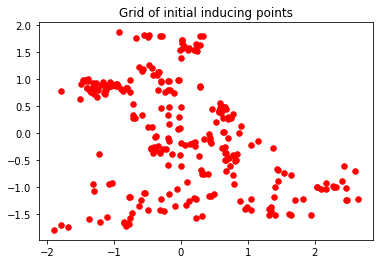

In [40]:
#train test split for 3 dimensional data
t_train, t_test, R_train, R_test, Y_train, Y_test = mutils.train_split_3d(t, R, Y, train_frac = TRAIN_FRAC, split_type = 'Cutoff')
Y = Y[:,:,0]

#get the mask of the test points
test_mask = np.in1d(t.squeeze(), t_test.squeeze())

#Scale the data
scaled_values = mutils.scale_2d_train_test_data(R, Y, R_train, R_test, Y_train, Y_test )
R_scaler, R_scaled, R_train_scaled, R_test_scaled, _, _, _, _ = scaled_values

#here get a list of scaled coordinates (frozen because at some point in time)
R_scaled_frozen = R_scaled[0]

# #Create a grid to perform prediction/interpolation on
r1, r2, Rplot = mutils.create_grid_from_coords(R = R_scaled_frozen, t = t, R_scaler = R_scaler, N_pixels = GRID_PIXELS, date_solar = None)

z = R_scaled[2, ...]

# #CHANGE THE INDUCING POINTS FOR THE SOLAR ALTITUDE TO BE EQUALLY SPACED ALONG THE TOTAL INTERVAL
# z[:,2] = np.linspace(solar_altitude.min(),solar_altitude.max(),  len(z))
    
plt.scatter(*zip(*z[:, :2]), marker='o', s=30, color='red')
plt.title('Grid of initial inducing points')


In [41]:
z_opt = z
#get lat-lon coordinates
# grid_coord = R_scaler.inverse_transform(np.array(np.c_[r1,r2]))
# longitude_grid, latitude_grid =  convert_lonlat(grid_coord[:, 0], grid_coord[:, 1])
longitude_sys_train, latitude_sys_train = convert_lonlat(R_train[:,:,0][0], R_train[:,:,1][0])
longitude_z, latitude_z = convert_lonlat(R_scaler.inverse_transform(z_opt)[:,0], R_scaler.inverse_transform(z_opt)[:,1])


/Users/SeanNassimiha/miniforge3/envs/mscjax_dev/lib/python3.8/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


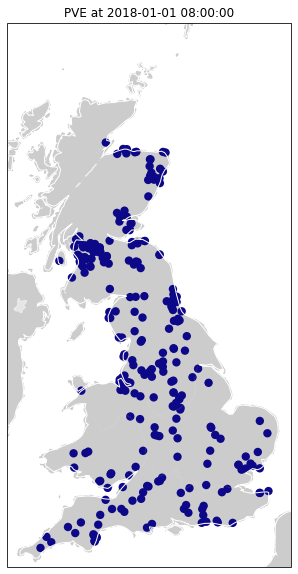

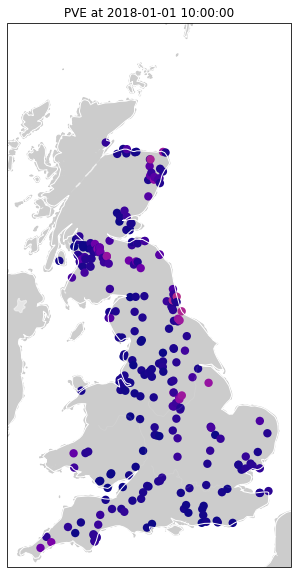

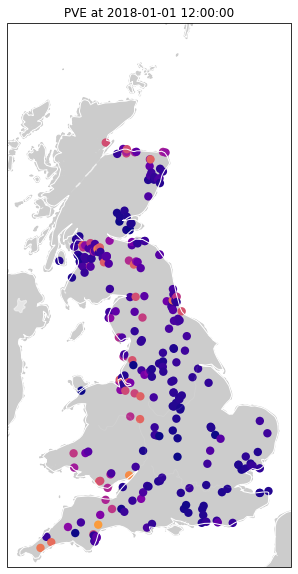

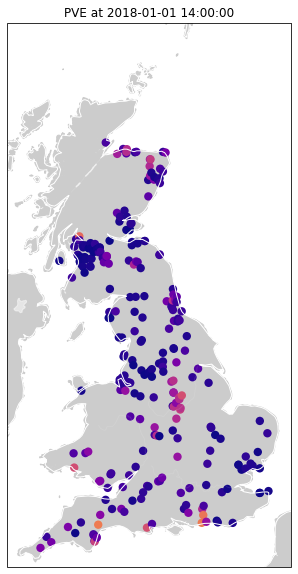

In [42]:
cmap = cm.plasma
vmin = np.nanpercentile(Y, 1)
vmax = np.nanpercentile(Y, 99)
#get the labels for the dates
dates = pd.to_datetime(data_multiple.datetime).dt.date
days_index = max(97, int(((len(t) / 5) // 97) * 97)) #number of time intervals to match 5 beginnings of days

for time_step in range(t.shape[0])[0:75:24]:
    f, a0 = plt.subplots(1, subplot_kw=dict(projection=ccrs.NorthPolarStereo()))
    
    a0.coastlines(resolution='50m', color='white')
    a0.add_feature(cfeat.LAKES, color='white', alpha=.5)
    a0.add_feature(cfeat.RIVERS, color='white', alpha=.1)
    a0.add_feature(cfeat.LAND, color=(0.8, 0.8, 0.8))

    a0.set_extent([-6, 2, 50, 60], ccrs.PlateCarree())  # lon_min,lon_max,lat_min,lat_max
    
    f.set_figheight(10)

    a0.scatter(longitude_sys_train, latitude_sys_train, cmap=cmap, vmin=vmin, vmax=vmax,
               c=np.squeeze(Y[time_step]), s=70, edgecolors='none', transform=ccrs.PlateCarree())
    
    a0.set_title(f'PVE at {data_multiple.datetime.unique()[time_step]}')
    a0.set_ylabel('Latitude')
    a0.set_xlabel('Longitude')
#     a1.vlines(t[time_step].item(), -1, 1, 'r')
#     a1.set_xlabel('time (days)')
#     a1.set_xlim(t[0], t[-1])
    
#     a1.set_xticks(np.asarray(t[1:-1:days_index ][:,0].tolist()))#, 
#     a1.set_xticklabels(dates[0:-1:days_index].values)
#     plt.subplots_adjust(wspace=0, hspace=0)
    
    plt.savefig(f'../figures/PVE_{data_multiple.datetime.unique()[time_step][-8:-6]}.png', dpi=300, bbox_inches='tight')
    plt.show()
    plt.close(f)
    

# PLOT FOR  LONDON ONLY

In [43]:
#DATA VARIABLES
SYSTEMS_NUM = 800
TIMESTEPS_NUM = 10000
TRAIN_FRAC = 200  #IF TRAIN_FRAC > 1 THEN IT BECOMES THE LENGTH OF THE TEST SET
GRID_PIXELS = 15

#OPTIMISATION VARIABLES
LR_ADAM = 0.01
LR_NEWTON = 0.5
ITERS = 20

#GP Variables
VAR_Y = 0.3
LEN_SPACE = 0.2
LEN_ALTITUDE = 0.3

#PERIODIC KERNEL
VAR_PERIOD = 0.5
VAR_MATERN = 1
LEN_MATERN = 24 /  (TIMESTEPS_NUM / 100) #48
LEN_PERIOD = 400 /  (TIMESTEPS_NUM / 100)#24

#Want to use a sparse approximation
SPARSE = True
#Should we optimise the inducing points
OPT_Z = False  # will be set to False if SPARSE=SPARSE

#use a mean field approximation?
MEAN_FIELD = True
MINI_BATCH_SIZE = None #none if you don't want them
TEST_STATIONS = 0

In [44]:
uk_pv = pd.read_csv('../../../Data/system_metadata_location_rounded.csv')
uk_pv['ss_id_string'] = uk_pv['ss_id'].astype('str')
#data_multiple.plot(legend=False)
lats = dict(uk_pv.set_index('ss_id')['latitude_noisy'])
longs = dict(uk_pv.set_index('ss_id')['longitude_noisy'])

data =  pd.read_csv('../../../Data/pv_power_df_5day_capacity_scaled.csv', index_col='datetime')
#I AM SHUFFLING HERE
data_multiple = data.iloc[:,:SYSTEMS_NUM][:TIMESTEPS_NUM].reset_index()

stacked = mutils.stack_dataframe(data_multiple, lats, longs)
stacked = stacked[(stacked.latitude < 52.5) & (stacked.latitude > 50.5) & (stacked.longitude > -1) & (stacked.longitude < 1)]
capacities = uk_pv[uk_pv.ss_id_string.isin(data_multiple.columns)].set_index('ss_id_string')['kwp'].values * 1000


In [45]:
X = np.array(stacked[['epoch', 'longitude', 'latitude']])
Y = np.array(stacked[['PV']])
# convert to easting and northings
british_national_grid_coords = convert_bng(X[:, 1], X[:, 2])
X = np.vstack([X[:, 0],
              np.array(british_national_grid_coords[0]),
              np.array(british_national_grid_coords[1])]).T

#Create a space-time grid from X and Y
t, R, Y = bayesnewton.utils.create_spatiotemporal_grid(X, Y)
t = t / (TIMESTEPS_NUM / 100)



/Users/SeanNassimiha/miniforge3/envs/mscjax_dev/lib/python3.8/site-packages/geopandas/array.py:275: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  return GeometryArray(vectorized.points_from_xy(x, y, z), crs=crs)


Text(0.5, 1.0, 'Grid of initial inducing points')

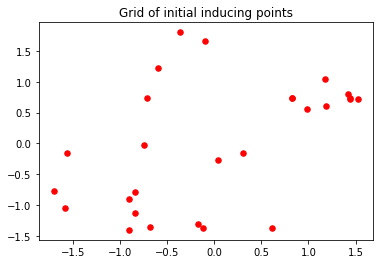

In [46]:
#train test split for 3 dimensional data
t_train, t_test, R_train, R_test, Y_train, Y_test = mutils.train_split_3d(t, R, Y, train_frac = TRAIN_FRAC, split_type = 'Cutoff')
Y = Y[:,:,0]

#get the mask of the test points
test_mask = np.in1d(t.squeeze(), t_test.squeeze())

#Scale the data
scaled_values = mutils.scale_2d_train_test_data(R, Y, R_train, R_test, Y_train, Y_test )
R_scaler, R_scaled, R_train_scaled, R_test_scaled, _, _, _, _ = scaled_values

#here get a list of scaled coordinates (frozen because at some point in time)
R_scaled_frozen = R_scaled[0]

# #Create a grid to perform prediction/interpolation on
r1, r2, Rplot = mutils.create_grid_from_coords(R = R_scaled_frozen, t = t, R_scaler = R_scaler, N_pixels = GRID_PIXELS, date_solar = None)

z = R_scaled[2, ...]

# #CHANGE THE INDUCING POINTS FOR THE SOLAR ALTITUDE TO BE EQUALLY SPACED ALONG THE TOTAL INTERVAL
# z[:,2] = np.linspace(solar_altitude.min(),solar_altitude.max(),  len(z))
    
plt.scatter(*zip(*z[:, :2]), marker='o', s=30, color='red')
plt.title('Grid of initial inducing points')

In [47]:
z_opt = z
#get lat-lon coordinates
# grid_coord = R_scaler.inverse_transform(np.array(np.c_[r1,r2]))
# longitude_grid, latitude_grid =  convert_lonlat(grid_coord[:, 0], grid_coord[:, 1])
longitude_sys_train, latitude_sys_train = convert_lonlat(R_train[:,:,0][0], R_train[:,:,1][0])
longitude_z, latitude_z = convert_lonlat(R_scaler.inverse_transform(z_opt)[:,0], R_scaler.inverse_transform(z_opt)[:,1])


/Users/SeanNassimiha/miniforge3/envs/mscjax_dev/lib/python3.8/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


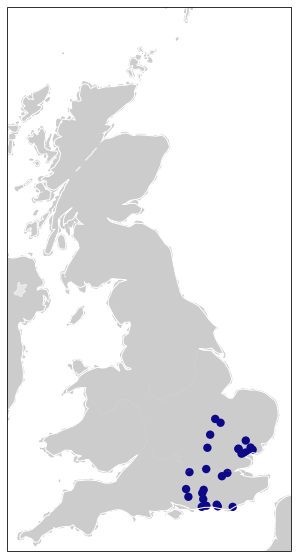

In [50]:
cmap = cm.plasma
vmin = np.nanpercentile(Y, 1)
vmax = np.nanpercentile(Y, 99)
#get the labels for the dates
dates = pd.to_datetime(data_multiple.datetime).dt.date
days_index = max(97, int(((len(t) / 5) // 97) * 97)) #number of time intervals to match 5 beginnings of days

time_step = 0
f, a0 = plt.subplots(1, subplot_kw=dict(projection=ccrs.NorthPolarStereo()))
    
a0.coastlines(resolution='50m', color='white')
a0.add_feature(cfeat.LAKES, color='white', alpha=.5)
a0.add_feature(cfeat.RIVERS, color='white', alpha=.1)
a0.add_feature(cfeat.LAND, color=(0.8, 0.8, 0.8))

a0.set_extent([-6, 2, 50, 60], ccrs.PlateCarree())  # lon_min,lon_max,lat_min,lat_max

f.set_figheight(10)

a0.scatter(longitude_sys_train, latitude_sys_train, cmap=cmap, vmin=vmin, vmax=vmax,
           c=np.squeeze(Y[time_step]), s=70, edgecolors='none', transform=ccrs.PlateCarree())

# a0.set_title(f'PVE locations for subsampled region')
a0.set_ylabel('Latitude')
a0.set_xlabel('Longitude')

plt.savefig(f'../figures/PVE_london.png', dpi=300, bbox_inches='tight')
plt.show()
plt.close(f)
